<a href="https://colab.research.google.com/github/ksee1230/NL_team12/blob/master/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC_Friends_12%EC%A1%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

모듈 import, 데이터 로드 및 one-hot encoding을 위한 전처리

In [ ]:
import pandas as pd
import json
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import nltk
from keras.utils import np_utils
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

urllib.request.urlretrieve("https://raw.githubusercontent.com/ksee1230/NL_team12/master/friends_train.json", filename="friends_train.json")
urllib.request.urlretrieve("https://raw.githubusercontent.com/ksee1230/NL_team12/master/en_data.csv", filename="friends_test.csv")

test_data = pd.read_csv('friends_test.csv', encoding='utf-8')

with open('friends_train.json') as json_file:
    json_data = json.load(json_file)

train_data = []
for data in json_data:
  train_data = train_data + data

for idx in train_data:
  if (idx['emotion'] == 'non-neutral'):
    idx['emotion_num'] = 0
  elif (idx['emotion'] == 'neutral'):
    idx['emotion_num'] = 1
  elif (idx['emotion'] == 'joy'):
    idx['emotion_num'] = 2
  elif (idx['emotion'] == 'sadness'):
    idx['emotion_num'] = 3
  elif (idx['emotion'] == 'fear'):
    idx['emotion_num'] = 4
  elif (idx['emotion'] == 'anger'):
    idx['emotion_num'] = 5
  elif (idx['emotion'] == 'surprise'):
    idx['emotion_num'] = 6
  elif (idx['emotion'] == 'disgust'):
    idx['emotion_num'] = 7

result = pd.DataFrame(train_data, columns=['annotation', 'emotion', 'emotion_num', 'utterance'])

print('훈련용 데이터 개수 :',len(result))

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
훈련용 데이터 개수 : 
      annotation  ...                                          utterance
0        4100000  ...  also I was the point person on my companys tr...
1        5000000  ...                   You mustve had your hands full.
2        5000000  ...                            That I did. That I did.
3        5000000  ...      So lets talk a little bit about your duties.
4        2000030  ...                             My duties?  All right.
...          ...  ...                                                ...
10556    3000011  ...                                         You or me?
10557    2100011  ...  I got it. Uh, Joey, women don't have Adam's ap...
10558    0000050  ...               You guys are messing with me, right?
10559    4000010  ...                  

# 데이터 정제


(1) 중복 데이터 제거 및 문장 기호 제거

In [ ]:
result['utterance'].nunique()

9291

In [ ]:
result.drop_duplicates(subset=['utterance'], inplace=True)

In [ ]:
print('총 샘플의 수 :',len(result))

총 샘플의 수 : 9291


In [ ]:
print(result.isnull().values.any())

False


In [ ]:
result['utterance'] = result['utterance'].str.replace("[^a-zA-Z ]","")
result[:5]

,annotation,emotion,emotion_num,utterance
0,4100000,neutral,1,also I was the point person on my companys tra...
1,5000000,neutral,1,You mustve had your hands full
2,5000000,neutral,1,That I did That I did
3,5000000,neutral,1,So lets talk a little bit about your duties
4,2000030,surprise,6,My duties All right


In [ ]:
result = result.dropna(how = 'any')
print(len(result))

9291


(2) 불용어 제거 및 토큰화

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
X_train = []
for sentence in result['utterance']:
    temp_X = []
    word_tokens = word_tokenize(sentence)
    for word in word_tokens:
      if word not in stop_words:
        temp_X.append(word)
    X_train.append(temp_X)

In [ ]:
print(X_train[:3])

[['also', 'I', 'point', 'person', 'companys', 'transition', 'KL', 'GR', 'system'], ['You', 'mustve', 'hands', 'full'], ['That', 'I', 'That', 'I']]


In [ ]:
X_test = []
for sentence in test_data['utterance']:
    temp_X = []
    word_tokens = word_tokenize(sentence)
    for word in word_tokens:
      if word not in stop_words:
        temp_X.append(word)
    X_test.append(temp_X)

(3) 정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

{'i': 1, 'oh': 2, 'im': 3, 'okay': 4, 'well': 5, 'yeah': 6, 'dont': 7, 'na': 8, 'know': 9, 'you': 10, 'right': 11, 'no': 12, 'hey': 13, 'thats': 14, 'go': 15, 'like': 16, 'gon': 17, 'get': 18, 'youre': 19, 'got': 20, 'yknow': 21, 'think': 22, 'really': 23, 'uh': 24, 'look': 25, 'what': 26, 'so': 27, 'one': 28, 'and': 29, 'mean': 30, 'see': 31, 'its': 32, 'want': 33, 'come': 34, 'cant': 35, 'ross': 36, 'sorry': 37, 'good': 38, 'all': 39, 'tell': 40, 'god': 41, 'guys': 42, 'joey': 43, 'great': 44, 'going': 45, 'but': 46, 'umm': 47, 'would': 48, 'ill': 49, 'could': 50, 'back': 51, 'yes': 52, 'time': 53, 'hes': 54, 'little': 55, 'say': 56, 'something': 57, 'love': 58, 'didnt': 59, 'we': 60, 'chandler': 61, 'guy': 62, 'wan': 63, 'ive': 64, 'monica': 65, 'this': 66, 'rachel': 67, 'hi': 68, 'phoebe': 69, 'ok': 70, 'said': 71, 'make': 72, 'the': 73, 'us': 74, 'thing': 75, 'how': 76, 'wait': 77, 'take': 78, 'shes': 79, 'why': 80, 'that': 81, 'people': 82, 'never': 83, 'thank': 84, 'maybe': 85, 

In [ ]:
total_cnt = len(tokenizer.word_index)
vocab_size = total_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 5935


In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
tokenizer = Tokenizer(vocab_size) 

In [ ]:
y_train = np_utils.to_categorical(result['emotion_num'])
num_classes = y_train.shape[1]

(4) 패딩

문장의 최대 길이 : 39
문장의 평균 길이 : 5.398019588849424


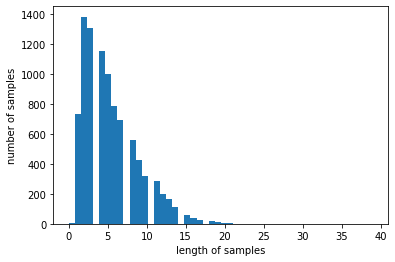

In [ ]:
print('문장의 최대 길이 :',max(len(l) for l in X_train))
print('문장의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 24
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 24 이하인 샘플의 비율: 99.96771068776235


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# 모델 설계 및 실행

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
ckpt = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[earlystop, ckpt], batch_size=128, validation_split=0.2)

Epoch 1/15
58/59 [============================>.] - ETA: 0s - loss: 1.6541 - acc: 0.4386
Epoch 00001: val_acc improved from -inf to 0.44325, saving model to best_model.h5
59/59 [==============================] - 6s 105ms/step - loss: 1.6540 - acc: 0.4385 - val_loss: 1.6091 - val_acc: 0.4432
Epoch 2/15
58/59 [============================>.] - ETA: 0s - loss: 1.5599 - acc: 0.4500
Epoch 00002: val_acc improved from 0.44325 to 0.45078, saving model to best_model.h5
59/59 [==============================] - 6s 95ms/step - loss: 1.5596 - acc: 0.4502 - val_loss: 1.6029 - val_acc: 0.4508
Epoch 3/15
58/59 [============================>.] - ETA: 0s - loss: 1.4401 - acc: 0.4969
Epoch 00003: val_acc did not improve from 0.45078
59/59 [==============================] - 6s 95ms/step - loss: 1.4394 - acc: 0.4972 - val_loss: 1.6622 - val_acc: 0.4088
Epoch 4/15
58/59 [============================>.] - ETA: 0s - loss: 1.3263 - acc: 0.5365
Epoch 00004: val_acc improved from 0.45078 to 0.46530, saving mode

모델을 통해 test 데이터에 대한 결과 예측 및 csv 변환

In [ ]:
loaded_model = load_model('best_model.h5')
prediction = loaded_model.predict_classes(X_test, verbose=0)

prediction = prediction.flatten().tolist()

prediction_emotion = []
for num in prediction:
  if num == 0:
    prediction_emotion.append('non-neutral')
  elif num == 1:
    prediction_emotion.append('neutral')
  elif num == 2:
    prediction_emotion.append('joy')
  elif num == 3:
    prediction_emotion.append('sadness')
  elif num == 4:
    prediction_emotion.append('fear')
  elif num == 5:
    prediction_emotion.append('anger')
  elif num == 6:
    prediction_emotion.append('surprise')
  elif num == 7:
    prediction_emotion.append('disgust')

id = list(range(len(prediction_emotion)))

dic = {'Id': id,
       'Predicted': prediction_emotion}

df = pd.DataFrame(dic)
df.to_csv('sample.csv', sep=',', index = False)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
